In [ ]:
import torch
import torch.fft
import matplotlib.pyplot as plt

class SignalGen:
    def __init__(self, fs=8192, T=1.0, frequencies=(9, 30, 300, 3000), amplitudes=(1, 1, 1, 1), noise_variance=0.09, seed=42):
        """
        Initializes the SignalGen class with parameters for signal generation.

        Args:
            fs (int): Sampling frequency in Hz.
            T (float): Duration of the signal in seconds.
            frequencies (tuple): A tuple of frequencies (in Hz) for the sinusoidal components.
            amplitudes (tuple): A tuple of amplitudes for each corresponding sinusoidal frequency.
            noise_variance (float): The variance of the Gaussian noise to be added to the signal.
            seed (int): Seed for the random number generator to ensure reproducibility.
        """
        self.fs = fs
        self.T = T
        self.frequencies = frequencies
        self.amplitudes = amplitudes
        self.noise_variance = noise_variance
        self.seed = seed

    def generate(self):
        """
        Generates a synthetic signal composed of multiple sinusoids and additive Gaussian noise.

        Returns:
            tuple:
                - t (torch.Tensor): A 1D tensor representing the time vector.
                - x_noisy (torch.Tensor): A 1D tensor representing the generated noisy signal.
        """
        # Set the random seed for PyTorch to ensure reproducible noise generation.
        import torch # Assuming torch is available in the environment. If not, this line would cause an error.
        torch.manual_seed(self.seed)

        # Calculate the total number of samples based on sampling frequency and duration.
        n_samples = int(self.fs * self.T)

        # Create a time vector from 0 to T seconds with n_samples points.
        # This represents the time instances at which the signal is sampled.
        t = torch.linspace(0, self.T, n_samples, dtype=torch.float32)

        # Generate the clean signal by summing multiple sinusoidal waves.
        # For each frequency and its corresponding amplitude, a sine wave is created
        # and added to x_clean.
        x_clean = sum(a * torch.sin(2 * torch.pi * f * t) for a, f in zip(self.amplitudes, self.frequencies))

        # Generate Gaussian noise.
        # The standard deviation of the noise is the square root of the noise_variance.
        # torch.randn(n_samples) generates random numbers from a standard normal distribution (mean=0, variance=1).
        noise = torch.sqrt(torch.tensor(self.noise_variance)) * torch.randn(n_samples)

        # Add the generated noise to the clean signal to create the noisy signal.
        x_noisy = x_clean + noise

        # Return the time vector and the noisy signal.
        return t, x_noisy

In [ ]:
class PSDAnalyzer:
    def __init__(self, fs=8192):
        """
        Initializes the PSDAnalyzer class.

        Args:
            fs (int): Sampling frequency in Hz, used for PSD calculations.
        """
        self.fs = fs

    def estimate_psd_periodogram(self, x):
        """
        Estimates the Power Spectral Density (PSD) of a signal using the Periodogram method.
        This method calculates the magnitude squared of the Discrete Fourier Transform (DFT).

        Args:
            x (torch.Tensor): The input signal (time-domain data).

        Returns:
            tuple:
                - freqs (torch.Tensor): Frequencies corresponding to the PSD estimates.
                - psd (torch.Tensor): Power Spectral Density values.
        """
        import torch # Assuming torch is available in the environment.
        N = len(x)
        # Compute the Fast Fourier Transform (FFT) of the signal.
        Xf = torch.fft.fft(x)

        # Calculate the Periodogram PSD.
        # PSD = |X(f)|^2 / (fs * N), where |X(f)|^2 is the squared magnitude of the FFT.
        psd = (Xf.real**2 + Xf.imag**2) / (self.fs * N) # This calculates |Xf|^2 / (fs * N)

        # Compute the frequencies corresponding to the FFT output.
        freqs = torch.fft.fftfreq(N, d=1.0/self.fs)

        # Select only the positive frequencies and corresponding PSD values,
        # as the PSD is symmetric for real-valued signals.
        positive = freqs >= 0
        return freqs[positive], psd[positive]

    def estimate_snr(self, signal, noise_var):
        """
        Estimates the Signal-to-Noise Ratio (SNR) of a signal in dB.

        Args:
            signal (torch.Tensor): The clean signal (without noise).
            noise_var (float): The variance of the noise added to the signal.

        Returns:
            float: The estimated SNR in dB.
        """
        import torch # Assuming torch is available in the environment.
        # Calculate the power of the clean signal.
        power_signal = torch.mean(signal ** 2)

        # Calculate SNR in linear scale.
        snr_linear = power_signal / noise_var

        # Convert SNR to decibels (dB).
        snr_db = 10 * torch.log10(snr_linear)

        # Print the SNR estimate and its components for informative purposes.
        print(f"SNR Estimate: {snr_db:.2f} dB (Signal Power: {power_signal:.4f}, Noise Var: {noise_var})")
        return snr_db.item()

    def plot_signal(self, t, x, title="Time-Domain Signal"):
        """
        Plots the time-domain signal.

        Args:
            t (torch.Tensor): The time vector.
            x (torch.Tensor): The signal amplitude values.
            title (str): Title for the plot.
        """
        import matplotlib.pyplot as plt # Assuming matplotlib is available.
        plt.figure(figsize=(10, 4))
        # Plot the signal. .cpu().numpy() is used to convert a PyTorch tensor to a NumPy array for plotting.
        plt.plot(t.cpu().numpy(), x.cpu().numpy(), linewidth=1)
        plt.xlim(0, t[-1].item()) # Set x-axis limits to the signal duration.
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(title)
        plt.grid(True)
        plt.tight_layout() # Adjust plot to prevent labels from overlapping.
        plt.show()

    def plot_psd(self, f, psd, label="Periodogram", title="PSD Estimate"):
        """
        Plots the Power Spectral Density (PSD) estimate on a semi-log scale (frequency on log scale, PSD in dB).

        Args:
            f (torch.Tensor): Frequencies corresponding to the PSD.
            psd (torch.Tensor): Power Spectral Density values (linear scale).
            label (str): Label for the PSD line in the plot legend.
            title (str): Title for the plot.
        """
        import matplotlib.pyplot as plt # Assuming matplotlib is available.
        import torch # Ensuring torch is available for calculations.
        # Convert PSD to decibels (dB) relative to the maximum PSD value.
        # A small epsilon (1e-12) is added to avoid log(0) issues.
        psd_db = 10 * torch.log10(psd / torch.max(psd) + 1e-12)

        plt.figure(figsize=(10, 4))
        # Plot PSD on a semi-log scale. .numpy() converts tensor to NumPy array.
        plt.semilogx(f.numpy(), psd_db.numpy(), label=label)
        plt.ylim(-60, 0) # Set y-axis limits for PSD in dB, typical for showing dynamic range.
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("PSD (dB)")
        plt.title(title)
        plt.grid(True)
        plt.legend() # Display legend with the label.
        plt.tight_layout()
        plt.show()

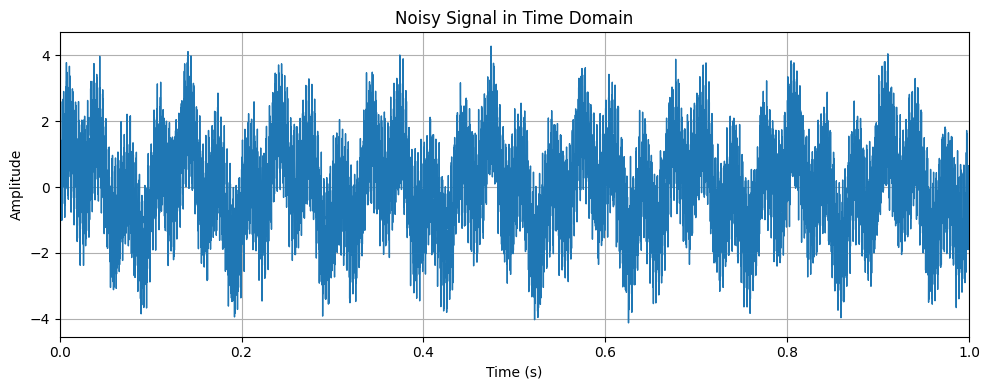

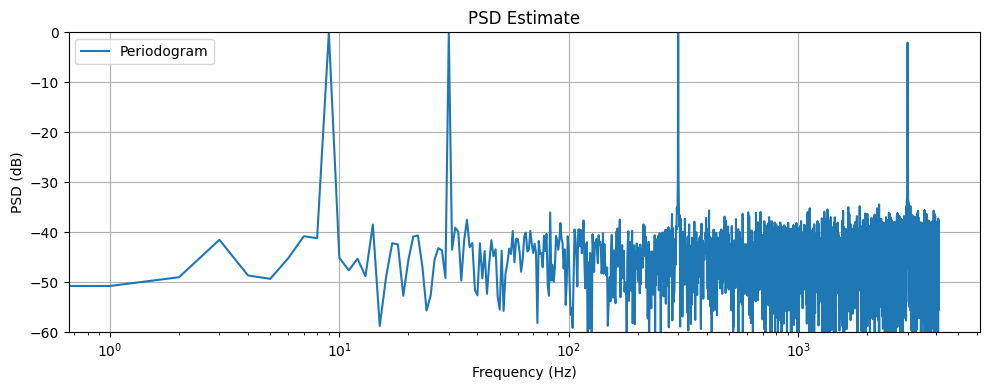

SNR Estimate: 13.67 dB (Signal Power: 2.0940, Noise Var: 0.09)


13.667244911193848

In [ ]:
# Demo usage

# Define the sampling frequency in Hz.
fs = 8192
# Define the duration of the signal in seconds.
T = 1.0
# Define the frequencies of the sinusoidal components in the signal.
frequencies = [9, 30, 300, 3000]
# Define the amplitudes for each corresponding frequency.
ampl = (1, 1, 1, 1)
# Define the noise variance (delta squared, here denoted as δ for noise_variance).
δ = 0.09 # Note: This variable name `δ` is used for `noise_variance` parameter in SignalGen.

# Instantiate the SignalGen class with the defined parameters.
generator = SignalGen(fs=fs, T=T, frequencies=frequencies, amplitudes=ampl, noise_variance=δ)
# Generate the time vector (t) and the noisy signal (x) using the generator.
t, x = generator.generate()

# Instantiate the PSDAnalyzer class with the defined sampling frequency.
analyzer = PSDAnalyzer(fs=fs)
# Estimate the Power Spectral Density (PSD) using the Periodogram method on the generated noisy signal.
# This returns the frequencies (f_psd) and the PSD values (psd).
f_psd, psd = analyzer.estimate_psd_periodogram(x)

# Plot the noisy signal in the time domain.
analyzer.plot_signal(t, x, title="Noisy Signal in Time Domain")
# Plot the estimated PSD using the Periodogram method.
analyzer.plot_psd(f_psd, psd, label="Periodogram")
# Estimate and print the Signal-to-Noise Ratio (SNR) of the generated signal.
# It uses the generated signal 'x' (which is the noisy signal containing both clean signal and noise)
# and the predefined noise variance for this calculation.
analyzer.estimate_snr(x, noise_var=0.09)

PSD values below 20 Hz:
Freq: 0.00 Hz, PSD: -120.00 dB
Freq: 1.00 Hz, PSD: -48.67 dB
Freq: 2.00 Hz, PSD: -49.89 dB
Freq: 3.00 Hz, PSD: -48.69 dB
Freq: 4.00 Hz, PSD: -48.17 dB
Freq: 5.00 Hz, PSD: -50.10 dB
Freq: 6.00 Hz, PSD: -44.15 dB
Freq: 7.00 Hz, PSD: -23.12 dB
Freq: 8.00 Hz, PSD: -12.40 dB
Freq: 9.00 Hz, PSD: -9.07 dB
Freq: 10.00 Hz, PSD: -12.39 dB
Freq: 11.00 Hz, PSD: -23.09 dB
Freq: 12.00 Hz, PSD: -43.32 dB
Freq: 13.00 Hz, PSD: -49.34 dB
Freq: 14.00 Hz, PSD: -49.72 dB
Freq: 15.00 Hz, PSD: -50.74 dB
Freq: 16.00 Hz, PSD: -50.76 dB
Freq: 17.00 Hz, PSD: -49.63 dB
Freq: 18.00 Hz, PSD: -49.07 dB
Freq: 19.00 Hz, PSD: -49.67 dB
PSD values below 20 Hz:
Freq: 0.00 Hz, PSD: -120.00 dB
Freq: 1.00 Hz, PSD: -48.67 dB
Freq: 2.00 Hz, PSD: -49.89 dB
Freq: 3.00 Hz, PSD: -48.69 dB
Freq: 4.00 Hz, PSD: -48.17 dB
Freq: 5.00 Hz, PSD: -50.10 dB
Freq: 6.00 Hz, PSD: -51.06 dB
Freq: 7.00 Hz, PSD: -51.34 dB
Freq: 8.00 Hz, PSD: -52.88 dB
Freq: 9.00 Hz, PSD: -51.21 dB
Freq: 10.00 Hz, PSD: -49.71 dB
Freq: 11.0

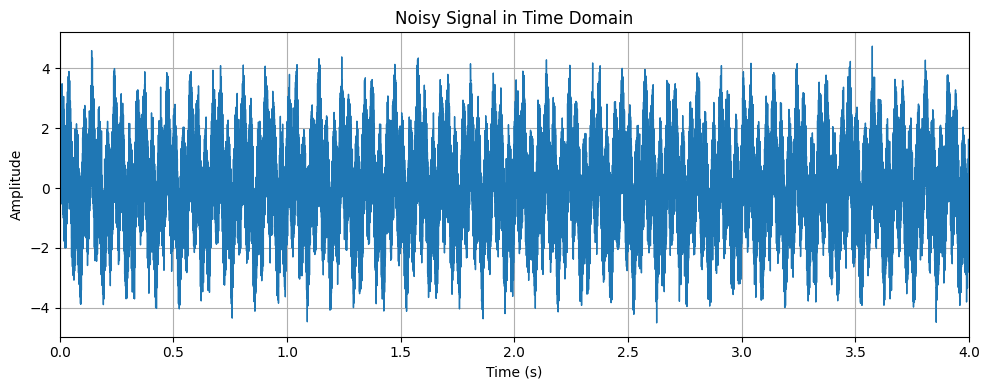

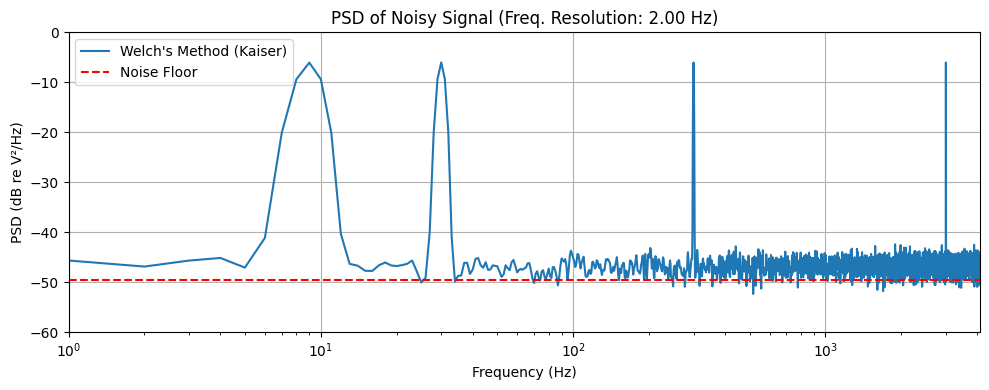

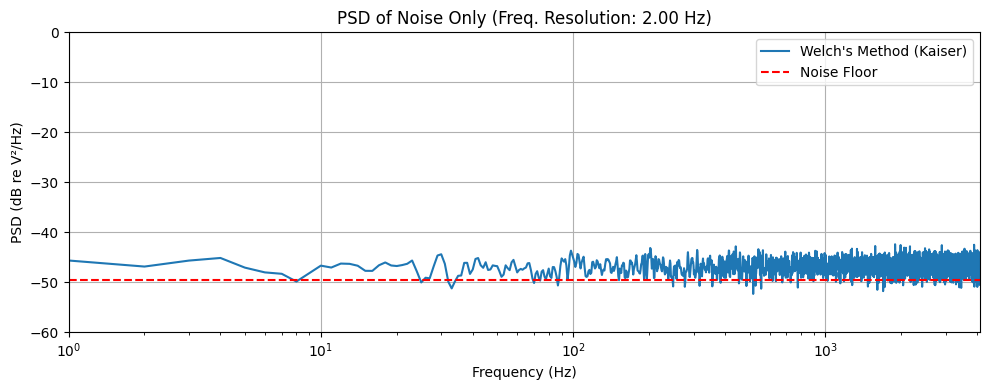

SNR Estimate: 13.47 dB (Signal Power: 1.9999, Noise Var: 0.09)


13.467742324066375

In [ ]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import numpy as np

class SignalGen:
    def __init__(self, fs=8192, T=4.0, frequencies=(9, 30, 300, 3000), amplitudes=(1, 1, 1, 1), noise_variance=0.09, seed=42):
        """
        Initializes the SignalGen class with parameters for signal generation.

        Args:
            fs (int): Sampling frequency in Hz.
            T (float): Duration of the signal in seconds.
            frequencies (tuple): Frequencies (in Hz) for the sinusoidal components.
            amplitudes (tuple): Amplitudes for each corresponding frequency.
            noise_variance (float): Variance of the Gaussian noise.
            seed (int): Seed for reproducibility.
        """
        self.fs = fs
        self.T = T
        self.frequencies = frequencies
        self.amplitudes = amplitudes
        self.noise_variance = noise_variance
        self.seed = seed

    def generate(self):
        """
        Generates a synthetic signal with sinusoids and Gaussian noise.

        Returns:
            tuple: (t, x_clean, x_noisy, noise)
                - t (torch.Tensor): Time vector.
                - x_clean (torch.Tensor): Clean signal (without noise).
                - x_noisy (torch.Tensor): Noisy signal.
                - noise (torch.Tensor): Noise component.
        """
        torch.manual_seed(self.seed)
        n_samples = int(self.fs * self.T)
        t = torch.linspace(0, self.T, n_samples, dtype=torch.float64)
        x_clean = sum(a * torch.sin(2 * torch.pi * f * t) for a, f in zip(self.amplitudes, self.frequencies))
        noise = torch.sqrt(torch.tensor(self.noise_variance, dtype=torch.float64)) * torch.randn(n_samples, dtype=torch.float64)
        x_noisy = x_clean + noise
        return t, x_clean, x_noisy, noise

class PSDAnalyzer:
    def __init__(self, fs=8192):
        """
        Initializes the PSDAnalyzer class.

        Args:
            fs (int): Sampling frequency in Hz.
        """
        self.fs = fs

    def estimate_psd_welch(self, x, nperseg=None, window='kaiser', beta=12.0):
        """
        Estimates PSD using Welch's method with windowing and segment averaging.

        Args:
            x (torch.Tensor): Input signal (time-domain).
            nperseg (int, optional): Length of each segment. Defaults to 8192.
            window (str): Window function ('hann', 'kaiser'). Default: 'kaiser'.
            beta (float): Kaiser window parameter.

        Returns:
            tuple: (freqs, psd)
                - freqs (torch.Tensor): Frequencies.
                - psd (torch.Tensor): PSD values (V²/Hz).
        """
        # Remove DC offset
        x = x - torch.mean(x)

        N = len(x)
        if nperseg is None:
            nperseg = 8192  # 1 Hz resolution for fs=8192
        nperseg = min(nperseg, N)

        # Create window
        if window == 'hann':
            win = torch.hann_window(nperseg, dtype=torch.float64)
        elif window == 'kaiser':
            win = torch.kaiser_window(nperseg, periodic=True, beta=beta, dtype=torch.float64)
        else:
            raise ValueError(f"Unsupported window: {window}")

        # Normalize window power
        win_power = torch.mean(win ** 2)
        n_overlap = int(nperseg * 0.75)  # 75% overlap
        n_segments = max(1, (N - n_overlap) // (nperseg - n_overlap))
        psd_sum = torch.zeros(nperseg // 2 + 1, dtype=torch.float64)

        # Compute periodogram for each segment
        for i in range(n_segments):
            start = i * (nperseg - n_overlap)
            end = start + nperseg
            segment = x[start:end] * win
            Xf = torch.fft.fft(segment)
            psd_segment = (Xf.real**2 + Xf.imag**2) / (self.fs * nperseg * win_power)
            psd_sum += psd_segment[:nperseg // 2 + 1]

        psd = psd_sum / n_segments
        psd[0] = 0.0  # Zero DC bin
        freqs = torch.linspace(0, self.fs / 2, nperseg // 2 + 1, dtype=torch.float64)

        # Debug: Print PSD values below 20 Hz
        idx_20hz = (freqs < 20.0).nonzero(as_tuple=True)[0]
        print("PSD values below 20 Hz:")
        for f, p in zip(freqs[idx_20hz], psd[idx_20hz]):
            print(f"Freq: {f:.2f} Hz, PSD: {10 * torch.log10(p + 1e-12):.2f} dB")

        return freqs, psd * 2  # Double for one-sided PSD

    def estimate_snr(self, signal_clean, noise_var):
        """
        Estimates SNR in dB.

        Args:
            signal_clean (torch.Tensor): Clean signal (without noise).
            noise_var (float): Noise variance.

        Returns:
            float: SNR in dB.
        """
        power_signal = torch.mean(signal_clean ** 2)
        snr_linear = power_signal / noise_var
        snr_db = 10 * torch.log10(snr_linear)
        print(f"SNR Estimate: {snr_db:.2f} dB (Signal Power: {power_signal:.4f}, Noise Var: {noise_var})")
        return snr_db.item()

    def plot_signal(self, t, x, title="Time-Domain Signal"):
        """
        Plots the time-domain signal.

        Args:
            t (torch.Tensor): Time vector.
            x (torch.Tensor): Signal amplitudes.
            title (str): Plot title.
        """
        plt.figure(figsize=(10, 4))
        plt.plot(t.cpu().numpy(), x.cpu().numpy(), linewidth=1)
        plt.xlim(0, t[-1].item())
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_psd(self, f, psd, noise_var, label="Welch", title="PSD Estimate"):
        """
        Plots PSD on a semi-log scale with noise floor reference.

        Args:
            f (torch.Tensor): Frequencies.
            psd (torch.Tensor): PSD values (linear scale).
            noise_var (float): Noise variance for reference line.
            label (str): Plot label.
            title (str): Plot title.
        """
        psd_db = 10 * torch.log10(psd + 1e-12)  # Convert to dB, avoid log(0)
        noise_floor = noise_var / self.fs
        noise_floor_db = 10 * np.log10(noise_floor + 1e-12)

        plt.figure(figsize=(10, 4))
        plt.semilogx(f.numpy(), psd_db.numpy(), label=label)
        plt.axhline(noise_floor_db, color='r', linestyle='--', label='Noise Floor')
        plt.xlim(1, self.fs / 2)
        plt.ylim(-60, 0)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("PSD (dB re V²/Hz)")
        plt.title(f"{title} (Freq. Resolution: {self.fs / len(psd):.2f} Hz)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Demo usage
fs = 8192
T = 4.0  # Increased duration
frequencies = [9, 30, 300, 3000]
ampl = (1, 1, 1, 1)
noise_variance = 0.09

generator = SignalGen(fs=fs, T=T, frequencies=frequencies, amplitudes=ampl, noise_variance=noise_variance)
t, x_clean, x_noisy, noise = generator.generate()

analyzer = PSDAnalyzer(fs=fs)
f_psd, psd = analyzer.estimate_psd_welch(x_noisy, nperseg=8192, window='kaiser', beta=12.0)
f_noise_psd, noise_psd = analyzer.estimate_psd_welch(noise, nperseg=8192, window='kaiser', beta=12.0)

analyzer.plot_signal(t, x_noisy, title="Noisy Signal in Time Domain")
analyzer.plot_psd(f_psd, psd, noise_var=noise_variance, label="Welch's Method (Kaiser)", title="PSD of Noisy Signal")
analyzer.plot_psd(f_noise_psd, noise_psd, noise_var=noise_variance, label="Welch's Method (Kaiser)", title="PSD of Noise Only")
analyzer.estimate_snr(x_clean, noise_var=noise_variance)